#Dataset

In [1]:
from dataset import *

In [2]:
import os
import pickle
import numpy as np
import torch

In [3]:
class dataset(Dataset):
    """Adaptive dataset."""

    def __init__(self,db_path='',ids_path='',part='',
                 labels_path=''
                 ):
        self.db_path=db_path       
        self.labels_path=labels_path
        self.ids_path=ids_path
        self.part=part
        
        pickle_in = open(self.ids_path,'rb')
        self.list_IDs= pickle.load(pickle_in)
        self.list_IDs=list(self.list_IDs)
        pickle_in.close()
        
        pickle_in = open(self.labels_path,'rb')
        self.labels = pickle.load(pickle_in)
        pickle_in.close()
        
        
    def __len__(self):
        return int(len(self.list_IDs))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        x=np.load(os.path.join(self.db_path,self.list_IDs[idx]+'.npy'))
        x=torch.from_numpy(x)
        x = (x.permute(2,0,1)).float()

        label = self.labels[self.list_IDs[idx]]
        label = np.array([label])
        label = label.astype('float32')
       
        return x,label

**TO EDIT**

In [4]:
train_data=dataset(db_path='./Features/resnet50/train/',
                        ids_path='train_ids.pickle',
                        labels_path='./scores.pickle'
                 )
                 
print(f"Length of Train Data : {len(train_data)}")


Length of Train Data : 839


#DataLoader

In [5]:
from torch.utils.data import  DataLoader

In [6]:
batch_size = 1
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

#Model

In [7]:
from timesformer.models.vit import TimeSformer
import torch.nn as nn

In [8]:
model = TimeSformer(img_size=50,num_classes=1,patch_size=1,num_frames=10,attention_type='divided_space_time')

Pretrained model URL is invalid, using random initialization.


#Train function

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import time
import copy
from tqdm import tqdm

In [10]:
def train_model(model, dataloaders,criterion, optimizer,norm=100,debut=0, num_epochs=25, is_inception=False,scheduler=None):
    since = time.time()

    val_loss_history = []
    loss_history = []
    best_loss=99999999
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(debut,num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for batch_idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase])):
                inputs = inputs.to(device, non_blocking=True)
                labels = (labels.to(device))/norm

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        action_loss=loss
                    preds = outputs

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        action_loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            loss_history.append(epoch_loss)

            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(dataloaders[phase]),
                100. * batch_idx / len(dataloaders[phase]), loss.item()))



            print('{} Loss: {:.4f} '.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            
      #  scheduler.step(val_loss_history[-1])
      
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    vloss_history={}
    vloss_history['val']=val_loss_history
    vloss_history['loss']=loss_history
   
    return model, vloss_history

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()

/home/hbrachem@admr.insa/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


#Train

In [12]:
num_epochs = 10
lr = 0.0001

In [13]:
model=model.float()
params_to_update=[]
for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
opt_func = torch.optim.Adam(params_to_update,lr=lr)
scheduler = ReduceLROnPlateau(opt_func, 'min' ,patience=5,verbose=True)
criterion = nn.MSELoss()

In [31]:
from torch.functional import norm
[model,history] = train_model(model,dataloaders={'train':train_dl},optimizer=opt_func,num_epochs=num_epochs,
                    criterion=criterion,scheduler=scheduler,norm=100)

Epoch 0/9
----------


839it [10:55,  1.28it/s]

train Loss: 0.0181 
Epoch 1/9
----------



839it [11:02,  1.27it/s]

train Loss: 0.0182 
Epoch 2/9
----------



839it [12:12,  1.15it/s]

train Loss: 0.0201 
Epoch 3/9
----------



839it [12:46,  1.10it/s]

train Loss: 0.0184 
Epoch 4/9
----------



839it [11:22,  1.23it/s]

train Loss: 0.0179 
Epoch 5/9
----------



839it [11:31,  1.21it/s]

train Loss: 0.0183 
Epoch 6/9
----------



839it [12:57,  1.08it/s]

train Loss: 0.0185 
Epoch 7/9
----------



839it [40:24,  2.89s/it]

train Loss: 0.0182 
Epoch 8/9
----------



839it [12:09,  1.15it/s]

train Loss: 0.0174 
Epoch 9/9
----------



839it [12:09,  1.15it/s]

train Loss: 0.0179 
Training complete in 147m 30s
Best val loss: 99999999.000000


In [32]:
import matplotlib.pyplot as plt

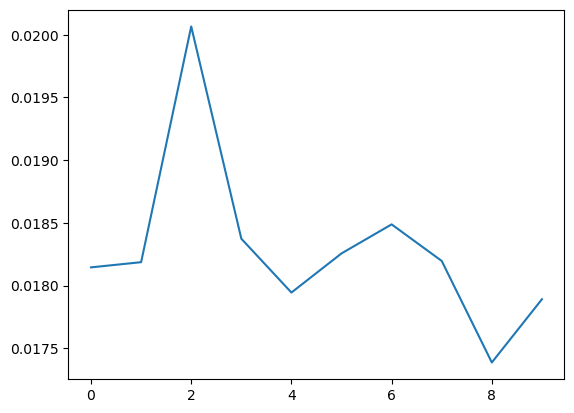

In [33]:
#plt.plot(range(len(history["val"])),history["val"])
plt.plot(range(len(history["loss"])),history["loss"])

#Test

In [34]:
def step(inputs):
    data, label = inputs
    #data=data.cuda()
    preds = model(data)
    return preds, label

In [35]:
with torch.no_grad():
    y_pred=[]
    label=[]
    for i, batch in enumerate(train_dl):
        pred,l = step(batch)
        y_pred.append(pred[0].cpu())
        label.append(float(l[0][0]))


In [36]:
import pandas
import scipy.io
import numpy as np
import argparse
import time
import math
import os
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from concurrent import futures
import functools
import warnings
warnings.filterwarnings("ignore")

def logistic_func(X, bayta1, bayta2, bayta3, bayta4):
  # 4-parameter logistic function
  logisticPart = 1 + np.exp(np.negative(np.divide(X - bayta3, np.abs(bayta4))))
  yhat = bayta2 + np.divide(bayta1 - bayta2, logisticPart)
  return yhat

def compute_metrics(y_pred, y):
  '''
  compute metrics btw predictions & labels
  '''
  # compute SRCC & KRCC
  SRCC = scipy.stats.spearmanr(y, y_pred)[0]
  try:
    KRCC = scipy.stats.kendalltau(y, y_pred)[0]
  except:
    KRCC = scipy.stats.kendalltau(y, y_pred, method='asymptotic')[0]

  # logistic regression btw y_pred & y
  beta_init = [np.max(y), np.min(y), np.mean(y_pred), 0.5]
  popt, _ = curve_fit(logistic_func, y_pred, y, p0=beta_init, maxfev=int(1e8))
  y_pred_logistic = logistic_func(y_pred, *popt)
  
  # compute  PLCC RMSE
  PLCC = scipy.stats.pearsonr(y, y_pred_logistic)[0]
  RMSE = np.sqrt(mean_squared_error(y, y_pred_logistic))
  return [SRCC, KRCC, PLCC, RMSE]

#Scores

In [37]:
y=[]
for i in range(len(y_pred)):
  y.append(y_pred[i].cpu()[0])

In [38]:
y_true=label

In [39]:
[SRCC, KRCC, PLCC, RMSE]=compute_metrics(y,y_true)

In [40]:
SRCC

0.004657626052325375

In [41]:
PLCC

0.07534895719316728

In [42]:
KRCC

0.004995228078572213

In [43]:
RMSE

12.899717838562337